In [1]:
import os

In [2]:
train_dir = os.path.join('C:/Users/Admin/Desktop/ML and DL/Railway\Dataset _ Railway Track Fault Detection/Train')
validation_dir = os.path.join('C:/Users/Admin/Desktop/ML and DL/Railway\Dataset _ Railway Track Fault Detection/Validiation')

# Directory with our training defective/nondefective pictures
train_defective_dir = os.path.join('C:/Users/Admin/Desktop/ML and DL/Railway\Dataset _ Railway Track Fault Detection/Train/Defective')
train_nondefective_dir = os.path.join('C:/Users/Admin/Desktop/ML and DL/Railway\Dataset _ Railway Track Fault Detection/Train/Non Defective')

# Directory with our validation defective/nondefective pictures
validation_defective_dir = os.path.join('C:/Users/Admin/Desktop/ML and DL/Railway\Dataset _ Railway Track Fault Detection/Validiation/Defective')
validation_nondefective_dir = os.path.join('C:/Users/Admin/Desktop/ML and DL/Railway\Dataset _ Railway Track Fault Detection/Validiation/Non Defective')

In [3]:
print('total training defective images :', len(os.listdir(train_defective_dir)))
print('total training non-defective images :', len(os.listdir(train_nondefective_dir)))


print('total validation defective images :', len(os.listdir( validation_defective_dir ) ))
print('total validation non-defective images :', len(os.listdir( validation_nondefective_dir) ))

total training defective images : 735
total training non-defective images : 735
total validation defective images : 159
total validation non-defective images : 158


In [4]:
train_defective_fnames = os.listdir(train_defective_dir )
train_nondefective_fnames = os.listdir( train_nondefective_dir)

print(train_defective_fnames[:5])
print(train_nondefective_fnames[:5])

['131004959_171473721383413_8222187747086021011_n.jpg', '131051004_382613492830631_1306891331783850055_n.jpg', '131065180_999185033824671_7735147288489715620_n.jpg', '131084537_190751489449739_279862595635733772_n.jpg', '131092897_149705809860659_8798464983059531038_n.jpg']
['aug_prefix_0_1023.jpg', 'aug_prefix_0_1052.jpg', 'aug_prefix_0_1060.jpg', 'aug_prefix_0_1073.jpg', 'aug_prefix_0_1113.jpg']


In [5]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 10x10 configuration
nrows = 10
ncols = 10

# Index for iterating over images
pic_index = 0

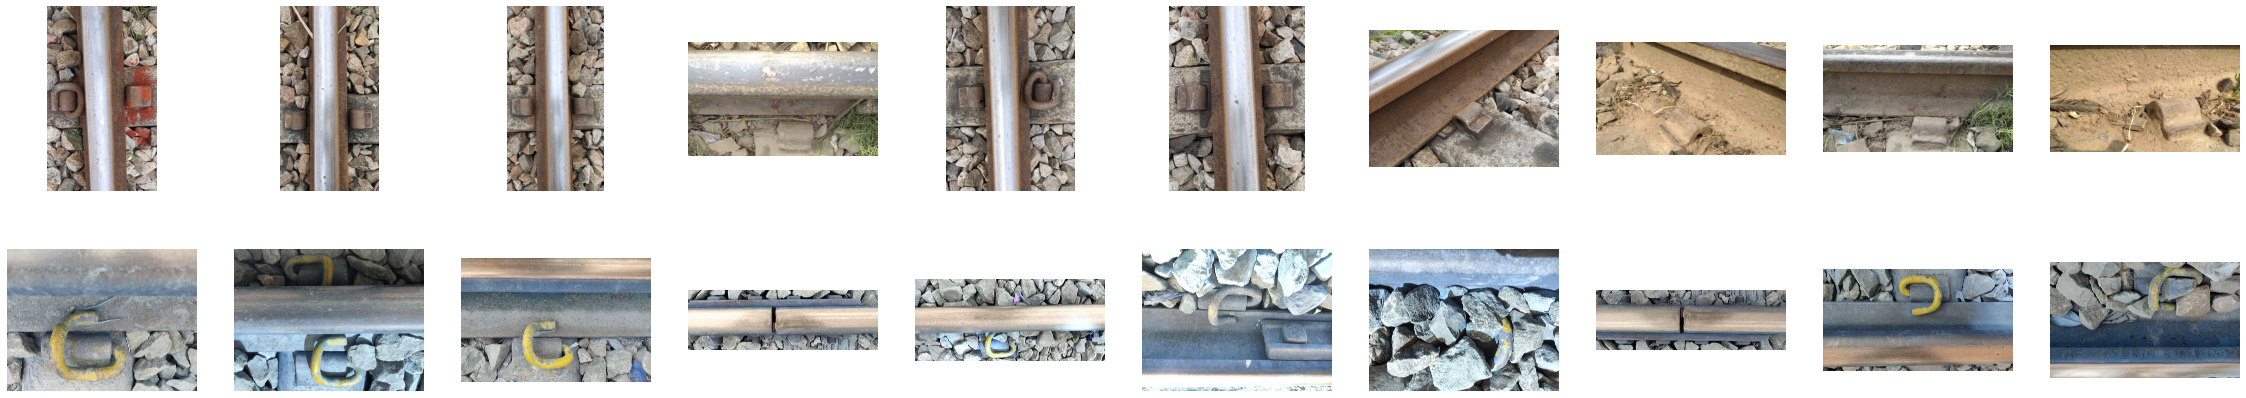

In [6]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 10
next_defective_pix = [os.path.join(train_defective_dir, fname) 
                for fname in train_defective_fnames[pic_index-10:pic_index]]
next_nondefective_pix = [os.path.join(train_nondefective_dir, fname) 
                for fname in train_nondefective_fnames[pic_index-10:pic_index]]


for i, img_path in enumerate(next_defective_pix+next_nondefective_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

In [7]:
import tensorflow as tf
import os
from tensorflow.keras import layers
from tensorflow.keras import Model
#from keras.applications.vgg16 import VGG16
#from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.applications import InceptionV3
# from keras.applications import Xception
# from keras.applications.inception_resnet_v2 import InceptionResNetV2
model = InceptionV3()

from keras.models import Model
# from keras.layers import concatenate
from keras.layers import Flatten, Dense, GlobalAveragePooling2D, Input, Embedding, SimpleRNN, LSTM, GRU, Reshape, Concatenate,Bidirectional
from keras.applications.inception_v3 import preprocess_input
#rom keras.applications.vgg16 import preprocess_input


from keras.layers import GaussianNoise
#local_weights_file = '../input/inceptionv3/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# f1_base = Xception(weights='imagenet', include_top=False, input_shape=(450,450,3))
f1_base = InceptionV3(weights='imagenet', include_top=False, input_shape=(300,300,3))
#f1_base.load_weights(local_weights_file)
f1_x = f1_base.output
f1_x = GlobalAveragePooling2D()(f1_x)

f1_x = Reshape([1,2048])(f1_x)  
'''f1_x = SimpleRNN(2048, 
            return_sequences=False,                       
            #dropout=0.8                                     
            input_shape=[1,2048])(f1_x)
'''
#Regularization with noise
f1_x = GaussianNoise(0.1)(f1_x)


f1_x = Dense(1024, activation='relu')(f1_x)

f1_x = Flatten()(f1_x)


f1_x = Dense(1, activation='sigmoid')(f1_x)
model_1 = Model(inputs=[f1_base.input],outputs=[f1_x])

print(model_1.summary())

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Using TensorFlow backend.




Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, 149, 149, 32) 96          conv2d_95[0][0]                  
__________________________________________________________________________________________________
activation_95 (Activation)      (None, 149, 149, 32) 0           batch_normalization_95[0][0]     
__________________________________________________________________________________________

In [8]:
from keras.callbacks import Callback
import pickle
import sys

#Stop training on val_acc
class EarlyStoppingByAccVal(Callback):
    def __init__(self, monitor='val_acc', value=0.00001, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current >= self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping" % epoch)
            self.model.stop_training = True

#Save large model using pickle formate instead of h5            
class SaveCheckPoint(Callback):
    def __init__(self, model, dest_folder):
        super(Callback, self).__init__()
        self.model = model
        self.dest_folder = dest_folder
        
        #initiate
        self.best_val_acc = 0
        self.best_val_loss = sys.maxsize #get max value
          
    def on_epoch_end(self, epoch, logs={}):
        val_acc = logs['val_acc']
        val_loss = logs['val_loss']

        if val_acc > self.best_val_acc:
            self.best_val_acc = val_acc
            
            # Save weights in pickle format instead of h5
            print('\nSaving val_acc %f at %s' %(self.best_val_acc, self.dest_folder))
            weigh= self.model.get_weights()

            #now, use pickle to save your model weights, instead of .h5
            #for heavy model architectures, .h5 file is unsupported.
            fpkl= open(self.dest_folder, 'wb') #Python 3
            pickle.dump(weigh, fpkl, protocol= pickle.HIGHEST_PROTOCOL)
            fpkl.close()
            
#             model.save('tmp.h5')
        elif val_acc == self.best_val_acc:
            if val_loss < self.best_val_loss:
                self.best_val_loss=val_loss
                
                # Save weights in pickle format instead of h5
                print('\nSaving val_acc %f at %s' %(self.best_val_acc, self.dest_folder))
                weigh= self.model.get_weights()

                #now, use pickle to save your model weights, instead of .h5
                #for heavy model architectures, .h5 file is unsupported.
                fpkl= open(self.dest_folder, 'wb') #Python 3
                pickle.dump(weigh, fpkl, protocol= pickle.HIGHEST_PROTOCOL)
                fpkl.close()

In [9]:
ls -l

 Volume in drive C has no label.
 Volume Serial Number is C4E5-F0D1

 Directory of C:\Users\Admin\Desktop



File Not Found


In [10]:
#Non-Groups
#Split training and validation
#Using Expert Data

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau
from keras.optimizers import Adam
# from keras.utils import multi_gpu_model

import time, os
from math import ceil
import multiprocessing

train_datagen = ImageDataGenerator(
    #rescale = 1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.6,
    horizontal_flip=True,
    vertical_flip=True,##
    brightness_range=[0.5, 1.5],##
    channel_shift_range=10,##
    fill_mode='nearest',
    preprocessing_function=preprocess_input,
)

test_datagen = ImageDataGenerator(
    #rescale = 1./255
    preprocessing_function = preprocess_input
)

NUM_GPU = 1
batch_size = 10

train_set = train_datagen.flow_from_directory('C:/Users/Admin/Desktop/ML and DL/Railway\Dataset _ Railway Track Fault Detection/Train',
                                                 target_size = (300,300),
                                                 batch_size = batch_size,
                                                 class_mode = 'binary',
                                                 shuffle=True,
                                                 seed=7,
#                                                  subset="training"
                                              )

valid_set = test_datagen.flow_from_directory('C:/Users/Admin/Desktop/ML and DL/Railway\Dataset _ Railway Track Fault Detection/Validiation',
                                                 target_size = (300,300),
                                                 batch_size = batch_size,
                                                 class_mode = 'binary',
                                                 shuffle=False,
                                                 seed=7,
#                                                  subset="validation"
                                             )

model_txt = 'st'
# Helper: Save the model.
savedfilename = os.path.join('checkpoints', 'SVHN_Inception_LRG299_STD.hdf5')

checkpointer = ModelCheckpoint(savedfilename,
                          monitor='val_acc', verbose=1, 
                          save_best_only=True, mode='max',save_weights_only=True)########

# Helper: TensorBoard
tb = TensorBoard(log_dir=os.path.join('svhn_output', 'logs', model_txt))

# Helper: Save results.
timestamp = time.time()
csv_logger = CSVLogger(os.path.join('svhn_output', 'logs', model_txt + '-' + 'training-' + \
    str(timestamp) + '.log'))

earlystopping = EarlyStoppingByAccVal(monitor='val_acc', value=0.9900, verbose=1)

#Using multiple models if more than 1 GPU
if NUM_GPU != 1:
    model_mul = multi_gpu_model(model_1, gpus=NUM_GPU)
else:
    model_mul = model_1
    
epochs = 150 ##!!!
lr = 1e-5
decay = lr/epochs
optimizer = Adam(lr=lr, decay=decay)

model_mul.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])

step_size_train=ceil(train_set.n/train_set.batch_size)
step_size_valid=ceil(valid_set.n/valid_set.batch_size)
# step_size_test=ceil(testing_set.n//testing_set.batch_size)

result = model_mul.fit_generator(
    generator = train_set, 
    steps_per_epoch = step_size_train,
    validation_data = valid_set,
    validation_steps = step_size_valid,
    shuffle=True,
    epochs=epochs,
#     callbacks=[earlystopping],
#     callbacks=[tb, csv_logger, checkpointer, earlystopping],        
    verbose=1)

Found 1469 images belonging to 2 classes.
Found 317 images belonging to 2 classes.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/150
147/147 [==============================] - 165s 1s/step - loss: 0.6273 - accuracy: 0.6487 - val_loss: 0.2744 - val_accuracy: 0.6215
Epoch 2/150
147/147 [==============================] - 145s 987ms/step - loss: 0.5342 - accuracy: 0.7223 - val_loss: 0.3237 - val_accuracy: 0.7476
Epoch 3/150
147/147 [==============================] - 143s 970ms/step - loss: 0.4667 - accuracy: 0.7720 - val_loss: 0.2635 - val_accuracy: 0.7666
Epoch 4/150
147/147 [==============================] - 145s 988ms/step - loss: 0.4275 - accuracy: 0.7992 - val_loss: 0.3674 - val_accuracy: 0.8013
Epoch 5/150
147/147 [==============================] - 144s 978ms/step - loss: 0.3751 - accuracy: 0.8325 - val_loss: 0.1372 - val_accuracy: 0.7792
Epoch 6/150
147/147 [==============================] - 143s 975ms/step - loss: 0.3441 - ac

147/147 [==============================] - 137s 929ms/step - loss: 0.1082 - accuracy: 0.9646 - val_loss: 0.2716 - val_accuracy: 0.8959
Epoch 53/150
147/147 [==============================] - 138s 942ms/step - loss: 0.0785 - accuracy: 0.9700 - val_loss: 0.1955 - val_accuracy: 0.8991
Epoch 54/150
147/147 [==============================] - 138s 937ms/step - loss: 0.1095 - accuracy: 0.9626 - val_loss: 0.0558 - val_accuracy: 0.8612
Epoch 55/150
147/147 [==============================] - 138s 941ms/step - loss: 0.0706 - accuracy: 0.9735 - val_loss: 0.3038 - val_accuracy: 0.9054
Epoch 56/150
147/147 [==============================] - 138s 939ms/step - loss: 0.0816 - accuracy: 0.9687 - val_loss: 0.0737 - val_accuracy: 0.8896
Epoch 57/150
147/147 [==============================] - 140s 954ms/step - loss: 0.0895 - accuracy: 0.9721 - val_loss: 0.1666 - val_accuracy: 0.8896
Epoch 58/150
147/147 [==============================] - 139s 948ms/step - loss: 0.0708 - accuracy: 0.9782 - val_loss: 0.1081 

147/147 [==============================] - 135s 918ms/step - loss: 0.0475 - accuracy: 0.9830 - val_loss: 1.0670 - val_accuracy: 0.9117
Epoch 108/150
147/147 [==============================] - 139s 947ms/step - loss: 0.0423 - accuracy: 0.9871 - val_loss: 1.1752 - val_accuracy: 0.9180
Epoch 109/150
147/147 [==============================] - 138s 936ms/step - loss: 0.0550 - accuracy: 0.9843 - val_loss: 0.4971 - val_accuracy: 0.9085
Epoch 110/150
147/147 [==============================] - 137s 933ms/step - loss: 0.0429 - accuracy: 0.9857 - val_loss: 0.9235 - val_accuracy: 0.8927
Epoch 111/150
147/147 [==============================] - 139s 946ms/step - loss: 0.0400 - accuracy: 0.9850 - val_loss: 0.7286 - val_accuracy: 0.8991
Epoch 112/150
147/147 [==============================] - 136s 922ms/step - loss: 0.0378 - accuracy: 0.9864 - val_loss: 0.7014 - val_accuracy: 0.8959
Epoch 113/150
147/147 [==============================] - 136s 928ms/step - loss: 0.0469 - accuracy: 0.9823 - val_loss: 0

In [11]:
import numpy as np
print(result.history['val_accuracy'])
print(np.mean(result.history['val_accuracy']))
print(np.max(result.history['val_accuracy']))

print(result.history['accuracy'])
print(np.mean(result.history['accuracy']))
print(np.max(result.history['accuracy']))

[0.6214510798454285, 0.7476340532302856, 0.7665615081787109, 0.801261842250824, 0.7791798114776611, 0.7444794774055481, 0.7886435389518738, 0.8044164180755615, 0.7791798114776611, 0.85173499584198, 0.8454258441925049, 0.8548895716667175, 0.8611987233161926, 0.8454258441925049, 0.8264984488487244, 0.8391166925430298, 0.85173499584198, 0.8580441474914551, 0.8454258441925049, 0.85173499584198, 0.8548895716667175, 0.8422712683677673, 0.8107255697250366, 0.8296530246734619, 0.85173499584198, 0.8328076004981995, 0.85173499584198, 0.7949526906013489, 0.8233438730239868, 0.8611987233161926, 0.8611987233161926, 0.8138801455497742, 0.85173499584198, 0.8990536332130432, 0.8706624507904053, 0.8927444815635681, 0.921135663986206, 0.9116719365119934, 0.921135663986206, 0.8832807540893555, 0.9053627848625183, 0.8990536332130432, 0.8990536332130432, 0.886435329914093, 0.8990536332130432, 0.8675078749656677, 0.8832807540893555, 0.9179810881614685, 0.8832807540893555, 0.8958990573883057, 0.8517349958419

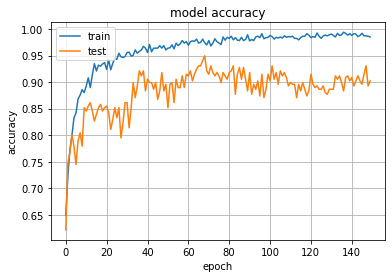

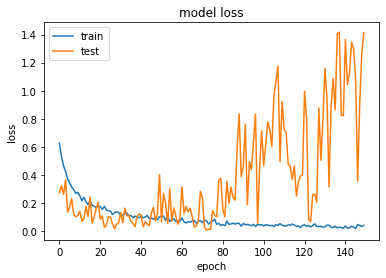

<Figure size 432x288 with 0 Axes>

In [12]:
import matplotlib.pyplot as plt
history = result
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()
plt.savefig('AccVal_acc')
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('LossVal_loss')